In [417]:
import numpy as np
import matplotlib.pyplot as plt
import properscoring as ps
import pyreadr
from isodisreg import idr
import pandas as pd

In [418]:
def interval_score(
    observations,
    alpha,
    q_left=None,
    q_right=None,
):

    sharpness = q_right - q_left
    calibration = (
        (
            np.clip(q_left - observations, a_min=0, a_max=None)
            + np.clip(observations - q_right, a_min=0, a_max=None)
        )
        * 2
        / alpha
    )
    total = sharpness + calibration
    return total, sharpness, calibration

In [616]:
exp = "exp_5"
data_path = f'../data/{exp}/data/'
result_path = f'../data/{exp}/results/'
model = "whitmat"

In [617]:
test_predictions = np.load(result_path+f"cnn_interval_{model}_test.npy")
test_parameters = np.load(result_path+f"cnn_{model}_test.npy")[1]
prediction = np.load(result_path+f"cnn_{model}_test.npy")[0]

test_samples = test_parameters.shape[0]

## Examples

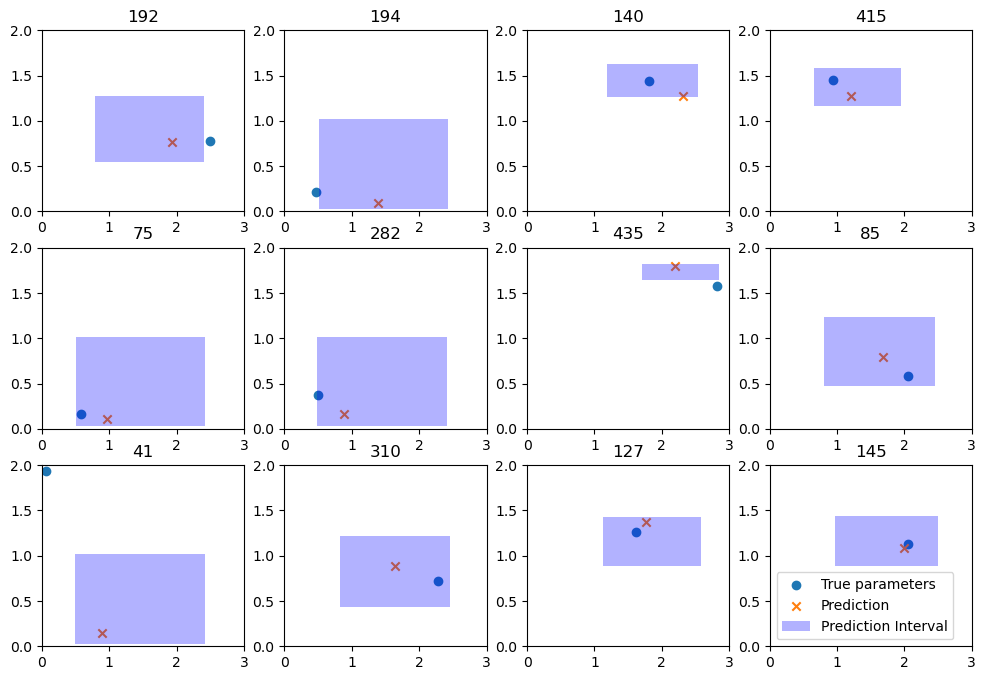

In [618]:
samples = np.random.randint(0,test_samples,12)
fig, axs = plt.subplots(3,4,figsize = (12,8))
axs = axs.ravel()
for x,i in enumerate(samples):
    axs[x].scatter(test_parameters[i,0], test_parameters[i,1], marker = "o", label = "True parameters")
    axs[x].scatter(prediction[i,0], prediction[i,1], marker = "x", label = "Prediction")
    
    anchor = (test_predictions[0,i,0], test_predictions[0,i,1])
    rectangle = plt.Rectangle(anchor, (test_predictions[1,i,0]-test_predictions[0,i,0]), (test_predictions[1,i,1]-test_predictions[0,i,1]), fc='blue', label = "Prediction Interval", alpha = 0.3)
    axs[x].add_patch(rectangle)
    axs[x].set_xlim(0,3)
    axs[x].set_ylim(0,2)
    axs[x].set_title(f"{i}")
axs[x].legend(["True parameters", "Prediction", "Prediction Interval"])

## Computed scores and coverage

In [619]:
r_coverage = np.sum((test_parameters[:,0] >= test_predictions[0,:,0]) & ((test_parameters[:,0] <= test_predictions[1,:,0])))/test_samples*100
s_coverage = np.sum((test_parameters[:,1] >= test_predictions[0,:,1]) & ((test_parameters[:,1] <= test_predictions[1,:,1])))/test_samples*100

In [620]:
r_is, _, _ = interval_score(test_parameters[:,0], 0.05, test_predictions[0,:,0], test_predictions[1,:,0])
r_is = np.mean(r_is)
s_is, _, _ = interval_score(test_parameters[:,1], 0.05, test_predictions[0,:,1], test_predictions[1,:,1])
s_is = np.mean(s_is)

In [621]:
print(f"Model: {model}\nCoverage {r_coverage:.2f}%, {s_coverage:.2f}% \nIS: {r_is:.4f}, {s_is:.4f}")

Model: whitmat
Coverage 66.00%, 65.60% 
IS: 4.8515, 4.0544


# With quantile score

In [540]:
exp = "exp_5"
data_path = f'../data/{exp}/data/'
result_path = f'../data/{exp}/results/'
model = "whitmat"

In [541]:
test_predictions = np.load(result_path+f"cnn_interval_{model}_test.npy")
test_parameters = np.load(result_path+f"cnn_{model}_test.npy")[1]
prediction = np.load(result_path+f"cnn_{model}_test.npy")[0]

test_samples = test_parameters.shape[0]

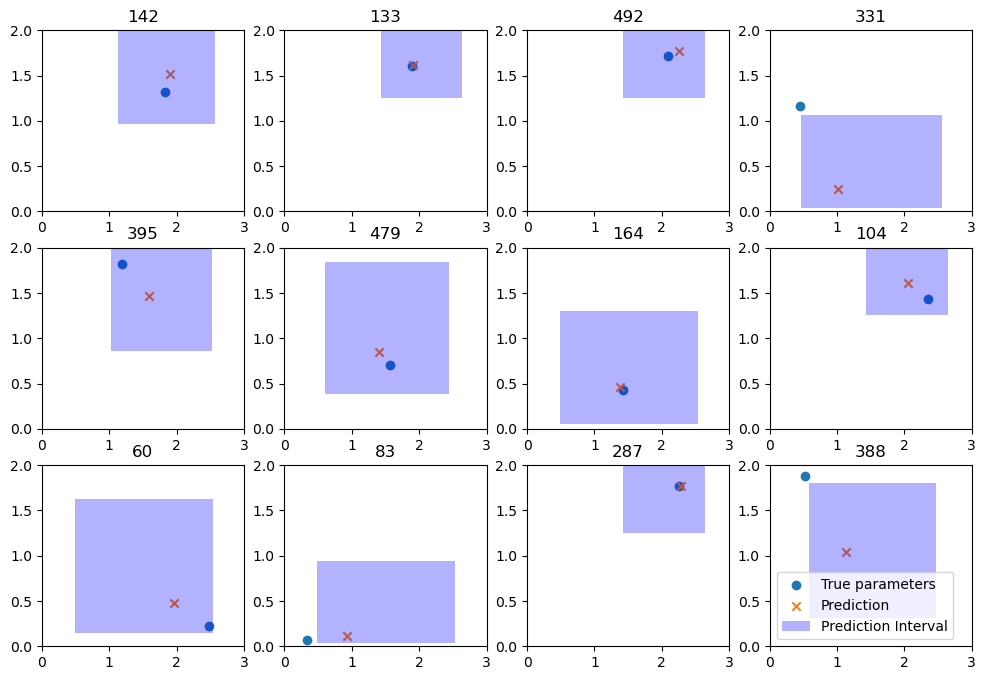

In [542]:
samples = np.random.randint(0,test_samples,12)
fig, axs = plt.subplots(3,4,figsize = (12,8))
axs = axs.ravel()
for x,i in enumerate(samples):
    axs[x].scatter(test_parameters[i,0], test_parameters[i,1], marker = "o", label = "True parameters")
    axs[x].scatter(prediction[i,0], prediction[i,1], marker = "x", label = "Prediction")
    
    anchor = (test_predictions[0,i,0], test_predictions[0,i,1])
    rectangle = plt.Rectangle(anchor, (test_predictions[1,i,0]-test_predictions[0,i,0]), (test_predictions[1,i,1]-test_predictions[0,i,1]), fc='blue', label = "Prediction Interval", alpha = 0.3)
    axs[x].add_patch(rectangle)
    axs[x].set_xlim(0,3)
    axs[x].set_ylim(0,2)
    axs[x].set_title(f"{i}")
axs[x].legend(["True parameters", "Prediction", "Prediction Interval"])

## Computed scores and coverage

In [543]:
r_coverage = np.sum((test_parameters[:,0] >= test_predictions[0,:,0]) & ((test_parameters[:,0] <= test_predictions[1,:,0])))/test_samples*100
s_coverage = np.sum((test_parameters[:,1] >= test_predictions[0,:,1]) & ((test_parameters[:,1] <= test_predictions[1,:,1])))/test_samples*100

In [544]:
r_is, _, _ = interval_score(test_parameters[:,0], 0.05, test_predictions[0,:,0], test_predictions[1,:,0])
r_is = np.mean(r_is)
s_is, _, _ = interval_score(test_parameters[:,1], 0.05, test_predictions[0,:,1], test_predictions[1,:,1])
s_is = np.mean(s_is)

In [545]:
print(f"Model: {model}\nCoverage {r_coverage:.2f}%, {s_coverage:.2f}% \nIS: {r_is:.4f}, {s_is:.4f}")

Model: whitmat
Coverage 66.20%, 80.80% 
IS: 4.7764, 3.5926
